# 04. Model Evaluation and Comparative Analysis

This notebook is used for detailed evaluation and comparison between the U-Net and Attention U-Net models.

In [20]:
%cd ~/Documents/DISSERTATION

/Users/t/Documents/DISSERTATION


In [21]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import yaml
from tqdm.notebook import tqdm
from scipy import stats

# Import modules
from models.unet import UNet
from models.attention_unet import AttentionUNet
from datasets import create_data_loaders
from utils.metrics import SegmentationMetrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


使用设备: cpu


In [23]:
# Load configuration and data
with open('configs/unet.yaml', 'r') as f:
    config = yaml.safe_load(f)

train_loader, val_loader, test_loader, pos_weight = create_data_loaders(config)
print(f"Test set size: {len(test_loader.dataset)}")


Loaded 246 samples for train split
Loaded 246 samples for val split
Loaded 212 samples for test split
测试集大小: 212


In [25]:
# ========== U-Net ==========
try:
    unet_ckpt_path = 'checkpoints/unet/best_model.pt'  
    unet_ckpt = torch.load(unet_ckpt_path, map_location=device, weights_only=False)

    # Use model config from checkpoint to ensure consistency in channels/layers
    unet_cfg = unet_ckpt.get('config', {}).get('model', {}).copy()
    if not unet_cfg:
        unet_model = UNet(in_channels=1, out_channels=1).to(device)
    else:
        unet_cfg.pop('name', None)  
        unet_model = UNet(**unet_cfg).to(device)

    unet_model.load_state_dict(unet_ckpt['model_state_dict'])
    print("U-Net model loaded successfully.")
except Exception as e:
    print("Failed to load U-Net model:", e)

# ========== Attention U-Net ==========
try:
    attn_ckpt_path = 'checkpoints/attention_unet/best_model.pt'  
    attn_ckpt = torch.load(attn_ckpt_path, map_location=device, weights_only=False)

    attn_cfg = attn_ckpt.get('config', {}).get('model', {}).copy()
    if not attn_cfg:
        attention_model = AttentionUNet(in_channels=1, out_channels=1).to(device)
    else:
        attn_cfg.pop('name', None)
        attention_model = AttentionUNet(**attn_cfg).to(device)

    attention_model.load_state_dict(attn_ckpt['model_state_dict'])
    print("Attention U-Net model loaded successfully.")
except Exception as e:
    print("Failed to load Attention U-Net model:", e)

unet_model.eval()
attention_model.eval()



U-Net模型加载成功
Attention U-Net模型加载成功


AttentionUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.15, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout2d(p=0.15, inplace=False)
          (4): Conv2d(128, 128,

In [27]:
# Evaluation function
def evaluate_model(model, dataloader, model_name):
    model.eval()
    metrics = SegmentationMetrics()
    
    print(f"Evaluating {model_name}...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Testing {model_name}'):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            outputs = model(images)
            metrics.update(outputs, masks)
    
    return metrics.compute()

# Evaluate both models
unet_results = evaluate_model(unet_model, test_loader, 'U-Net')
attention_results = evaluate_model(attention_model, test_loader, 'Attention U-Net')


评估U-Net...


测试U-Net:   0%|          | 0/14 [00:00<?, ?it/s]

评估Attention U-Net...


测试Attention U-Net:   0%|          | 0/14 [00:00<?, ?it/s]

In [29]:
# Compare results
print("=== Test Set Results Comparison ===")
print(f"{'Metric':<12} {'U-Net':<12} {'Attention U-Net':<15} {'Improvement':<10}")
print("-" * 55)

metrics_to_compare = ['dice', 'iou', 'precision', 'recall', 'accuracy']
for metric in metrics_to_compare:
    unet_val = unet_results[metric]
    attn_val = attention_results[metric]
    improvement = attn_val - unet_val
    
    print(f"{metric.upper():<12} {unet_val:<12.4f} {attn_val:<15.4f} {improvement:+.4f}")

dice_improvement = attention_results['dice'] - unet_results['dice']
print(f"\nSummary: Attention U-Net {'improved' if dice_improvement > 0 else 'decreased'} the Dice score by {abs(dice_improvement):.4f}")


=== 测试集结果对比 ===
指标           U-Net        Attention U-Net 提升        
-------------------------------------------------------
DICE         0.9557       0.9580          +0.0022
IOU          0.9164       0.9206          +0.0042
PRECISION    0.9581       0.9630          +0.0049
RECALL       0.9556       0.9551          -0.0005
ACCURACY     0.9779       0.9790          +0.0011

总结: Attention U-Net在Dice分数上提升了 0.0022


/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31590/1083217309.py:23: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31590/1083217309.py:23: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31590/1083217309.py:23: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31590/1083217309.py:23: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31590/1083217309.py:23: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv

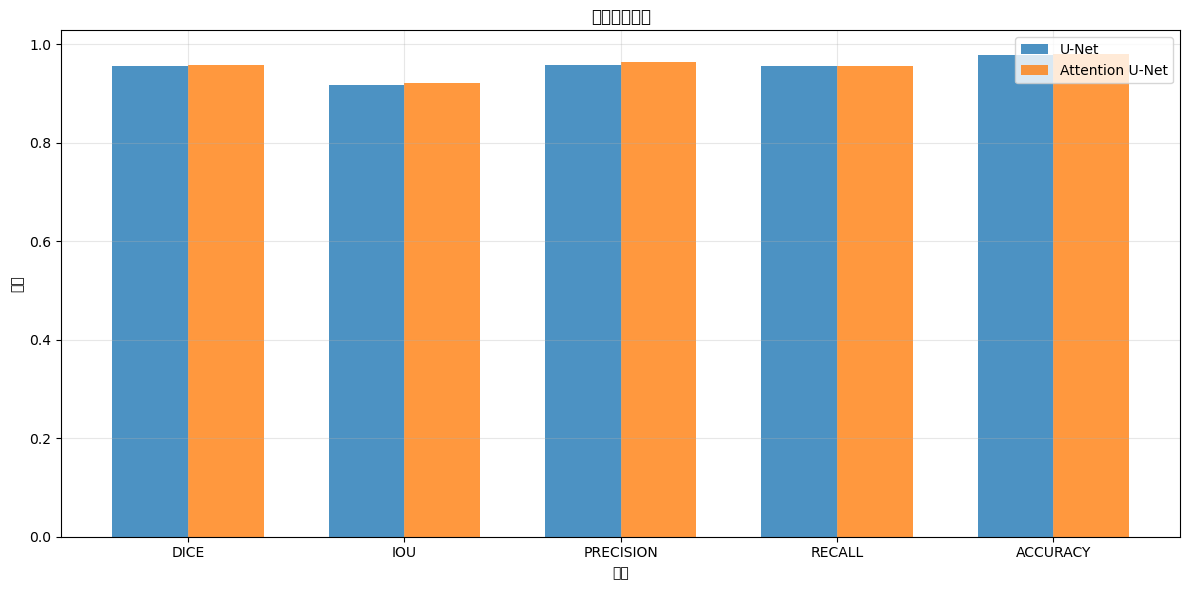

In [31]:
# Visualization: side-by-side comparison
import matplotlib.pyplot as plt

metrics_names = ['dice', 'iou', 'precision', 'recall', 'accuracy']
unet_values = [unet_results[m] for m in metrics_names]
attention_values = [attention_results[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, unet_values, width, label='U-Net', alpha=0.8)
ax.bar(x + width/2, attention_values, width, label='Attention U-Net', alpha=0.8)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics_names])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [33]:
# Save results
comparison_results = {
    'unet_results': unet_results,
    'attention_results': attention_results,
    'dice_improvement': float(dice_improvement),
    'better_model': 'Attention U-Net' if dice_improvement > 0 else 'U-Net'
}

os.makedirs('outputs/results', exist_ok=True)
with open('outputs/results/model_comparison.json', 'w') as f:
    json.dump(comparison_results, f, indent=2, default=str)

print("Comparison results saved to outputs/results/model_comparison.json")


对比结果已保存到 outputs/results/model_comparison.json

=== 评估完成! ===
